---
# Library importation
---

In [55]:
#Nettoyage/Visualisation des données
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Fonctions perso
from bibliotheque_ensta import *

#ML
import sklearn
from sklearn import ensemble
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
#from sklearn.feature_selection import RFECV, SequentialFeatureSelector

#import catboost

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#DL
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping

print("ok")

ok


In [56]:
#Rentrer nom de la base de données
base_de_donnees = 'SPMAuralB'
path = "/home4/datahome/rbessoua/comparaison/Vent/"+base_de_donnees+"/"
path

'/home4/datahome/rbessoua/comparaison/Vent/SPMAuralB/'

---
# Data importation/visualization
---

In [57]:
import os

nom_dir = "/home/datawork-osmose/dataset/"+base_de_donnees+"/analysis/getFeatures/32000/1H/"

os.chdir(nom_dir)
os.getcwd()

'/home/datawork-osmose/dataset/SPMAuralB/analysis/getFeatures/32000/1H'

In [58]:
ll = nom_dir + "complete.pkl"

[total_welch, total_tol, aux, total_time, frequencies] = pickle.load(open(ll, 'rb'))

In [59]:
X = prepa_total_tol_time(total_tol, total_time)

In [60]:
nom_dir = "/home/datawork-osmose/dataset/"+base_de_donnees+"/raw/auxiliary/"
os.chdir(nom_dir)
os.getcwd()

'/home/datawork-osmose/dataset/SPMAuralB/raw/auxiliary'

In [61]:
Y = pd.read_csv(base_de_donnees+'_y_final.csv')

In [62]:
data = pd.merge(X,Y, on=['year', 'month', 'day', 'hour'])
len(data)

1645

In [63]:
if base_de_donnees == "SPMAuralB" : None
else :
    data['w10'] = data['u10']
    for i in range(len(data)):
        data['w10'].loc[i] = root_mean_squarred(data['u10'].loc[i], data['v10'].loc[i])

In [64]:
if base_de_donnees == "SPMAuralB" :
    X = data.drop(['tp','w10'], axis=1)
else :
    X = data.drop(['tp', 'u10','v10','w10'], axis=1)

X_dl = X.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

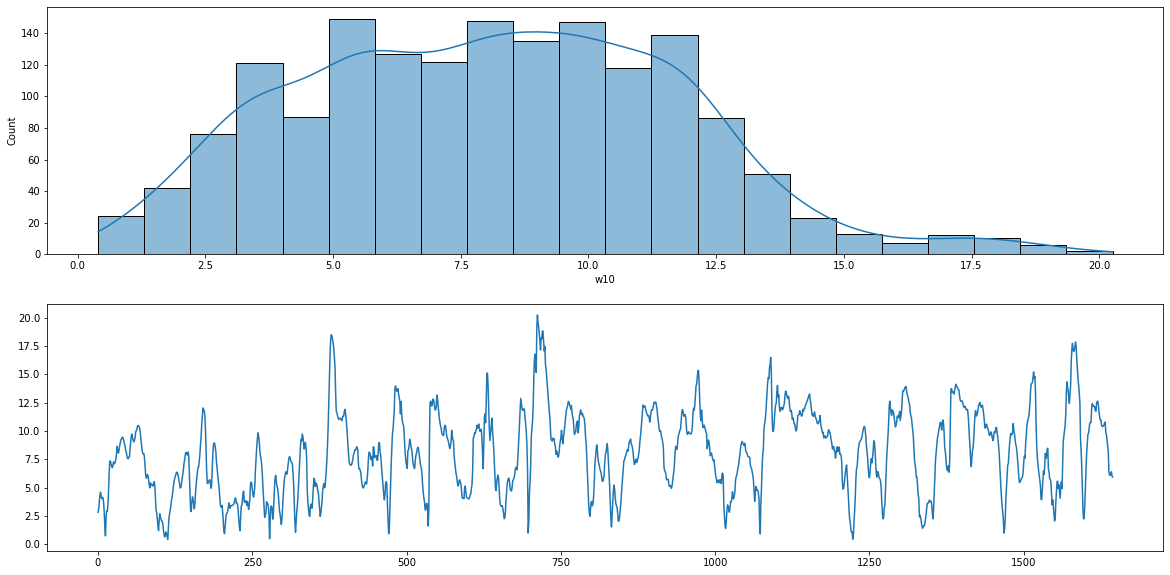

In [65]:
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(data.w10, kde=True)
plt.subplot(2,1,2)
plt.plot(data.w10)

In [66]:
data['w10'].describe()

count    1645.000000
mean        8.070856
std         3.649684
min         0.399286
25%         5.269014
50%         8.091429
75%        10.695283
max        20.261670
Name: w10, dtype: float64

Here we have a great wind speed distribution. Almost all wind levels are represented.

----------------------------
# Wind speed Estimation :
----------------------------

## First method : Random Forest

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,0.447612,0.973233,1.256995,0.764058,RF Vent


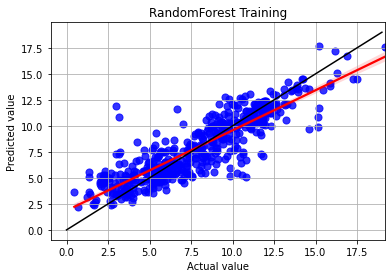

In [67]:
rf_vent, eval_model, Y_test, y_pred_test = test_model_rf('RF Vent', X, data['w10'], path=path+'70_rf_res.png',save=True)
eval_model

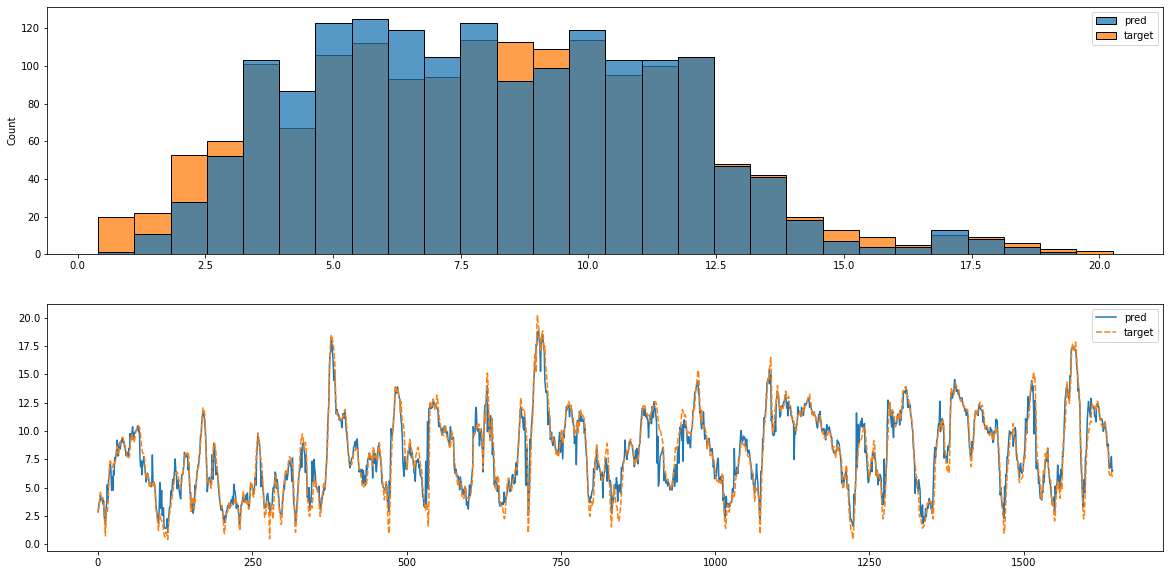

In [68]:
pred1 = rf_vent.predict(X)

histo = pd.DataFrame(data={'pred':pred1, 'target':data['w10']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_rf_figure.png')

In [69]:
print(f"The MSE is : {np.mean((data['w10'] - pred1)**2)}")

The MSE is : 1.1314788730490577


We train our model with 70% of the data.

We compare the distribution and repartition of the all dataset prediction and the target wind speed values.

We can see that de prediction fit the wind speed target and the prediction distribution fit approximately the target distribution. But we can think about over fitting.

## Second method : neural network implementation

Epoch 1/20
36/36 [==============================] - 1s 14ms/step - loss: 52.9619 - accuracy: 0.0000e+00 - val_loss: 10.7052 - val_accuracy: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 0s 7ms/step - loss: 10.6299 - accuracy: 0.0000e+00 - val_loss: 4.2939 - val_accuracy: 0.0000e+00
Epoch 3/20
36/36 [==============================] - 0s 7ms/step - loss: 7.4924 - accuracy: 0.0000e+00 - val_loss: 5.1105 - val_accuracy: 0.0000e+00
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 7.7569 - accuracy: 0.0000e+00 - val_loss: 3.9094 - val_accuracy: 0.0000e+00
Epoch 5/20
36/36 [==============================] - 0s 7ms/step - loss: 6.1578 - accuracy: 0.0000e+00 - val_loss: 4.2769 - val_accuracy: 0.0000e+00
Epoch 6/20
36/36 [==============================] - 0s 7ms/step - loss: 6.5591 - accuracy: 0.0000e+00 - val_loss: 4.5240 - val_accuracy: 0.0000e+00
Epoch 7/20
36/36 [==============================] - 0s 7ms/step - loss: 6.0509 - accuracy: 0.0000e+00 - val_

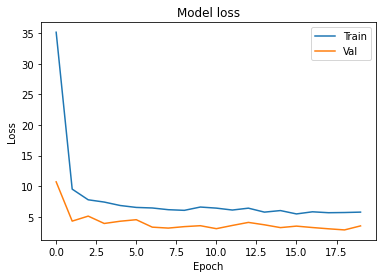

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,1.538526,0.697763,1.446517,0.716879,NN vent


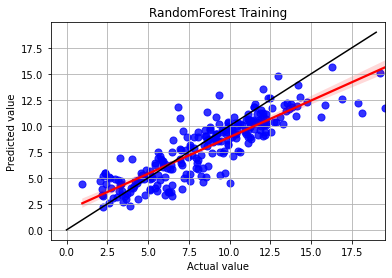

In [70]:
eval_nn_vent, model, hist = test_model_dl('NN vent', 3, 32, X, data['w10'], epochs=20, batch_size=32,path=path+'70_nn_res.png',save=True)
eval_nn_vent

***

**Our neural network converge, so it has finished his training.**

***

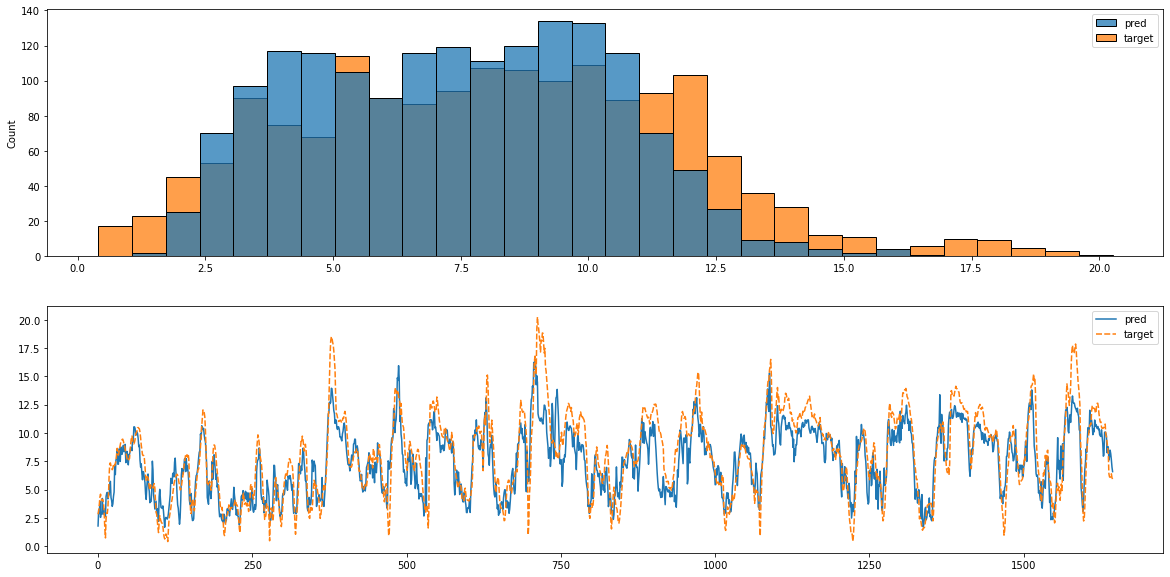

In [71]:
pred_nn_spams = model.predict(X_dl)
pred_nn_spams = pred_nn_spams.reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn_spams, 'target':data['w10']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_nn_figure.png')

In [72]:
print(f"The MSE is : {np.mean((data['w10'] - pred_nn_spams)**2)}")

The MSE is : 3.946795246504349


We train our model with 70% of the data.

We compare the distribution and repartition of the all dataset prediction and the target wind speed values.

The results with this model are less good than the Random Forest Model. But there seems to be less overfitting than with the first model.

## Amelioration of our regression model

We can see that our model has difficulties to predict low wind speed values and especially wind speed lower than 5m/s. So we will try to fixe that problem.
One idea could be first classifying high wind and low wind speed.

### Wind speed classification 

<AxesSubplot:xlabel='w10', ylabel='Count'>

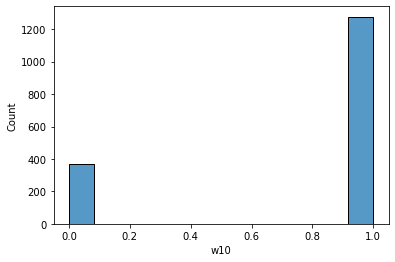

In [73]:
Y = (data['w10'] > 5)*1
sns.histplot(Y)

We can se we have approximately 1000 wind speed values lower than 5m/s. 

Now we will train a classifier.

### Neural network classifier

### Random Forest Classifier

AxesSubplot(0.125,0.125;0.62x0.755)


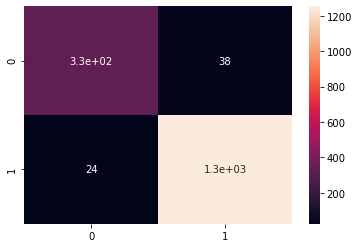

In [74]:
wind_classi, y_pred_classi = test_model_rf('', X, Y, type_model = 'classification')

In [75]:
Y_faible = data['w10'][(y_pred_classi == 0)]    
X_faible = X[(y_pred_classi == 0)]

Y_fort = data['w10'][(y_pred_classi == 1)]    
X_fort = X[(y_pred_classi == 1)]

In [76]:
idx_faible = np.where(y_pred_classi==0)
idx_fort = np.where(y_pred_classi==1)

<AxesSubplot:xlabel='w10', ylabel='Count'>

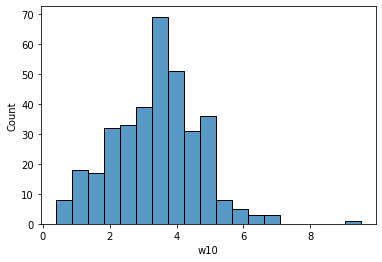

In [77]:
sns.histplot(Y_faible)

We can see our classifier works well because he misclassified only 19 wind speed.

Now we will make the regression.

### Random Forest regression

#### Low wind speed regression

   Train MAE  Train R2  Test MAE   Test R2                   Résultat
0   0.361905  0.864229  0.936843  0.139995  RF Regr pluie GliderSPAms


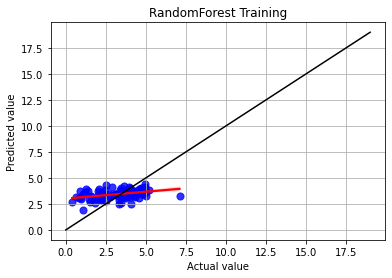

In [78]:
rf_faible, eval_model_faible, Y_test, y_pred_faible = test_model_rf('RF Regr pluie GliderSPAms', X_faible, Y_faible)
print(eval_model_faible)

<AxesSubplot:>

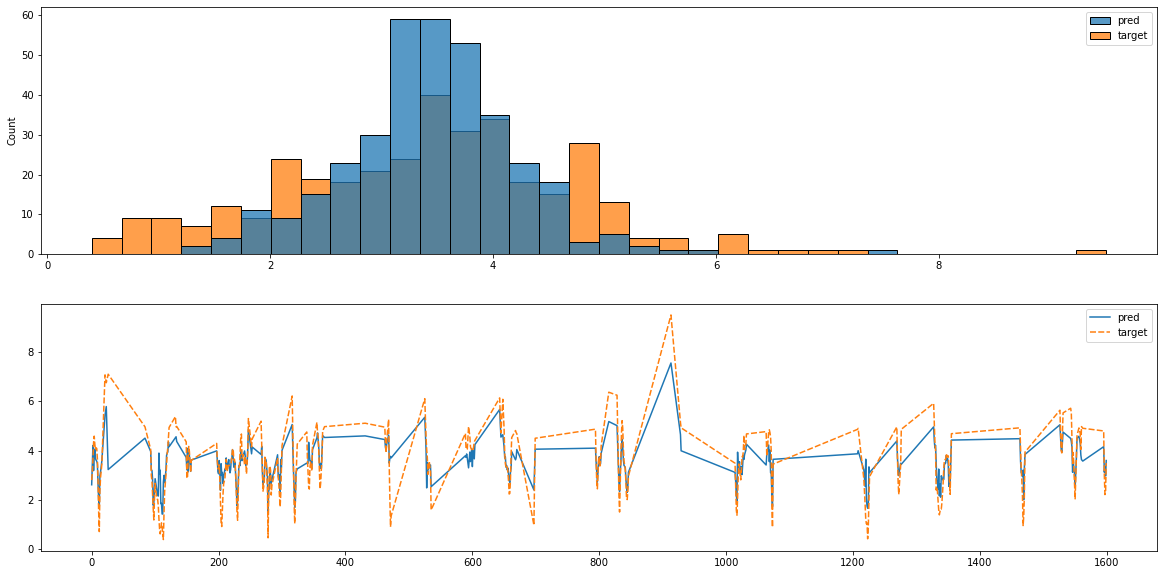

In [79]:
pred_faible2 = rf_faible.predict(X_faible).reshape(-1)

histo = pd.DataFrame(data={'pred':pred_faible2, 'target':Y_faible})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

#### Strong wind speed prediction

   Train MAE  Train R2  Test MAE   Test R2                   Résultat
0   0.429615  0.961731  1.035335  0.759257  RF Regr pluie GliderSPAms


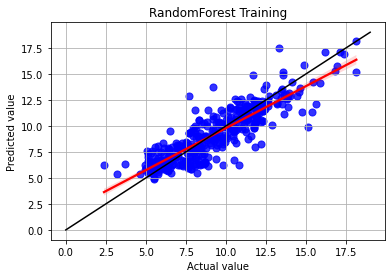

In [80]:
rf_fort, eval_model_fort, Y_test, y_pred_fort = test_model_rf('RF Regr pluie GliderSPAms', X_fort, Y_fort)
print(eval_model_fort)

<AxesSubplot:>

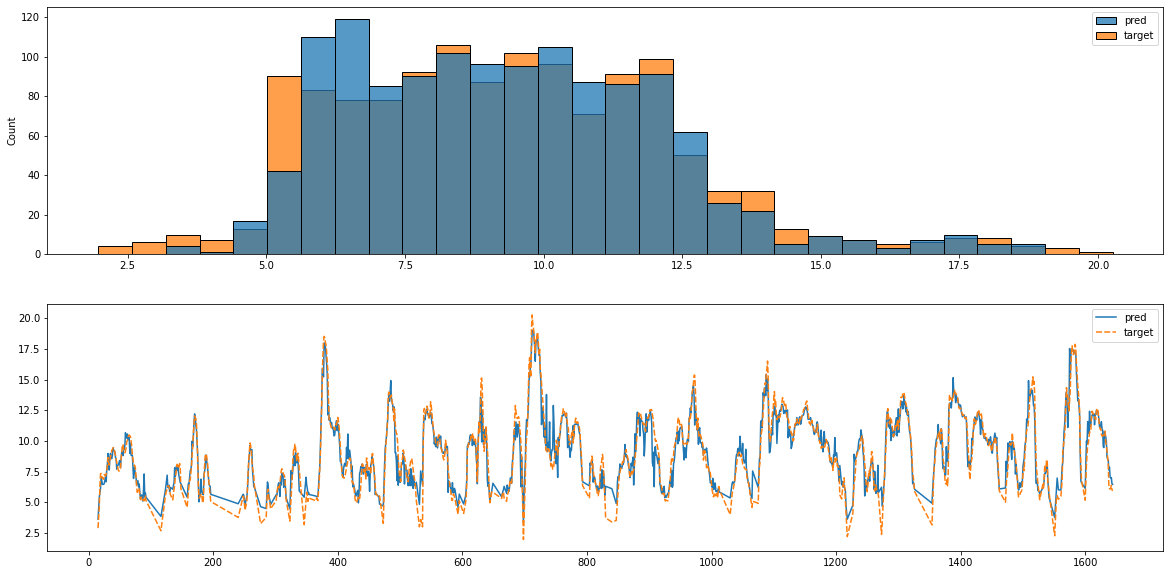

In [81]:
pred_fort2 = rf_fort.predict(X_fort).reshape(-1)

histo = pd.DataFrame(data={'pred':pred_fort2, 'target':Y_fort})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

***Final Prediction :***

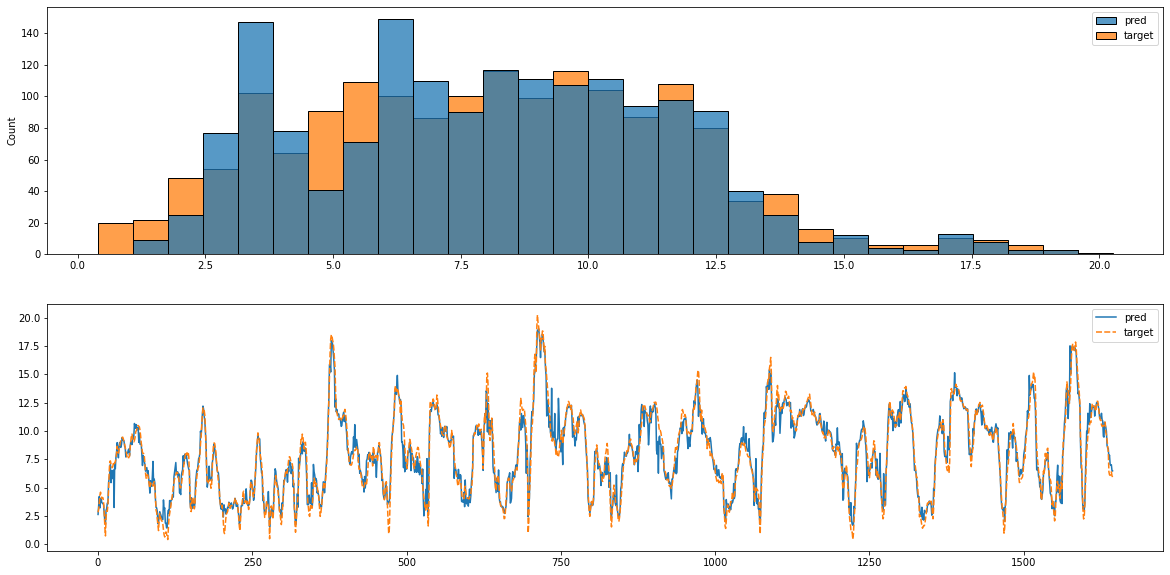

In [82]:
res2=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res2[j] = pred_faible2[i]
for i, j in enumerate(idx_fort[0]):
    res2[j] = pred_fort2[i]

histo = pd.DataFrame(data={'pred':res2, 'target':data.w10})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_amelioration_rf_pred_finale.png')

In [83]:
print(f"The MSE is : {np.mean((data['w10'] - res2)**2)}")

The MSE is : 0.7684779546062408


We have less low values problems with method, but we have to be careful about overfitting.

### Neural network regression

Epoch 1/20
8/8 [==============================] - 1s 56ms/step - loss: 11.2808 - accuracy: 0.0000e+00 - val_loss: 4.4148 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 3.4280 - accuracy: 0.0000e+00 - val_loss: 2.4495 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 3.1163 - accuracy: 0.0000e+00 - val_loss: 3.2647 - val_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 2.7291 - accuracy: 0.0000e+00 - val_loss: 2.4161 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 0s 18ms/step - loss: 2.7180 - accuracy: 0.0000e+00 - val_loss: 2.6426 - val_accuracy: 0.0000e+00
Epoch 6/20
8/8 [==============================] - 0s 20ms/step - loss: 1.8607 - accuracy: 0.0000e+00 - val_loss: 2.6595 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 0s 18ms/step - loss: 1.9586 - accuracy: 0.0000e+00 - val_loss: 2.49

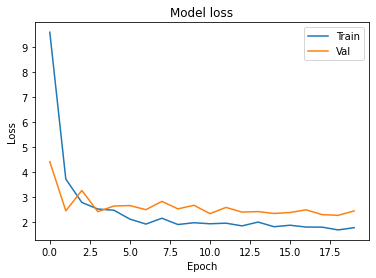

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,0.963818,0.065311,1.04997,-0.173534,NN Vent W1M3A


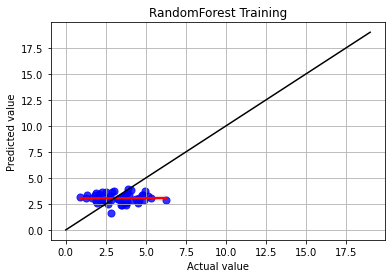

In [84]:
eval_nn_faible, model_faible, hist = test_model_dl('NN Vent W1M3A', 3, 32, X_faible, Y_faible, epochs=20, batch_size=32)
eval_nn_faible

<AxesSubplot:>

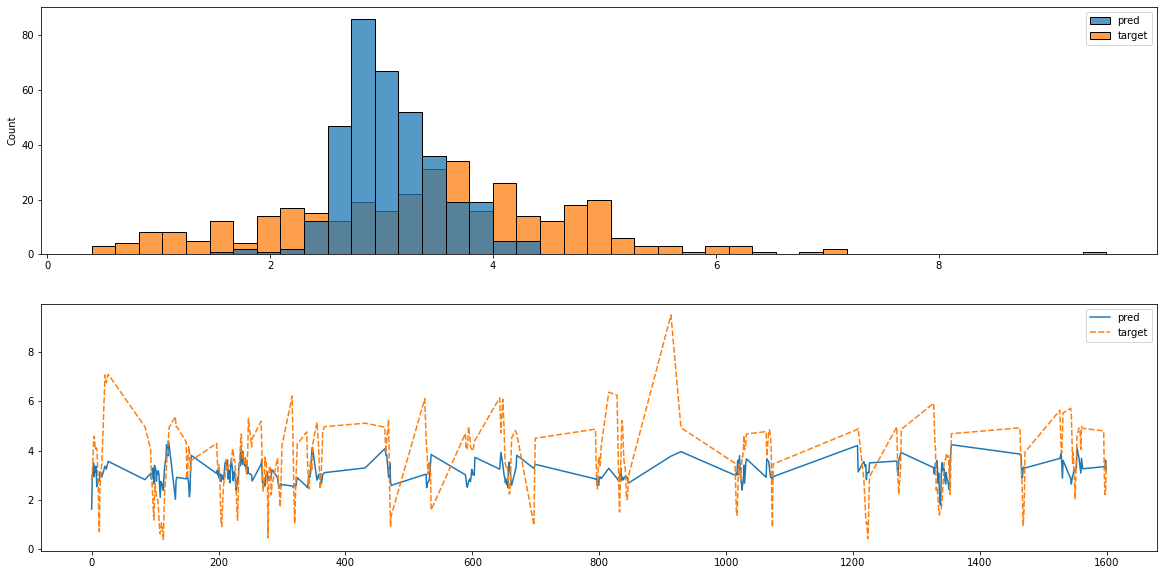

In [85]:
X_dl = X_faible.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn_faible = model_faible.predict(X_dl)
pred_nn_faible = pred_nn_faible.reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn_faible, 'target':Y_faible})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

Epoch 1/20
15/15 [==============================] - 1s 29ms/step - loss: 72.7369 - accuracy: 0.0000e+00 - val_loss: 11.3538 - val_accuracy: 0.0000e+00
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 18.5639 - accuracy: 0.0000e+00 - val_loss: 13.3551 - val_accuracy: 0.0000e+00
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 13.7536 - accuracy: 0.0000e+00 - val_loss: 5.9800 - val_accuracy: 0.0000e+00
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 9.4141 - accuracy: 0.0000e+00 - val_loss: 4.6176 - val_accuracy: 0.0000e+00
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 9.2899 - accuracy: 0.0000e+00 - val_loss: 4.0294 - val_accuracy: 0.0000e+00
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 8.3359 - accuracy: 0.0000e+00 - val_loss: 3.8224 - val_accuracy: 0.0000e+00
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 7.8604 - accuracy: 0.0000e+0

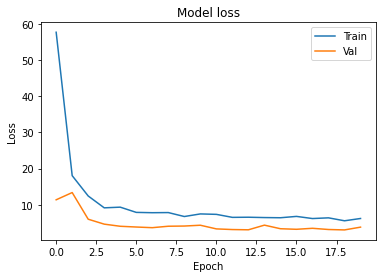

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,1.650533,0.480299,1.482869,0.520539,NN Vent W1M3A


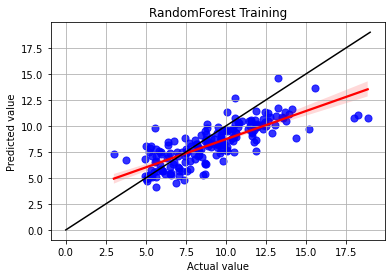

In [86]:
eval_nn_fort, model_fort, hist = test_model_dl('NN Vent W1M3A', 3, 32, X_fort, Y_fort, epochs=20, batch_size=64)
eval_nn_fort

In [87]:
#model_fort.save('nnvfort_spmaurala.h5')

<AxesSubplot:>

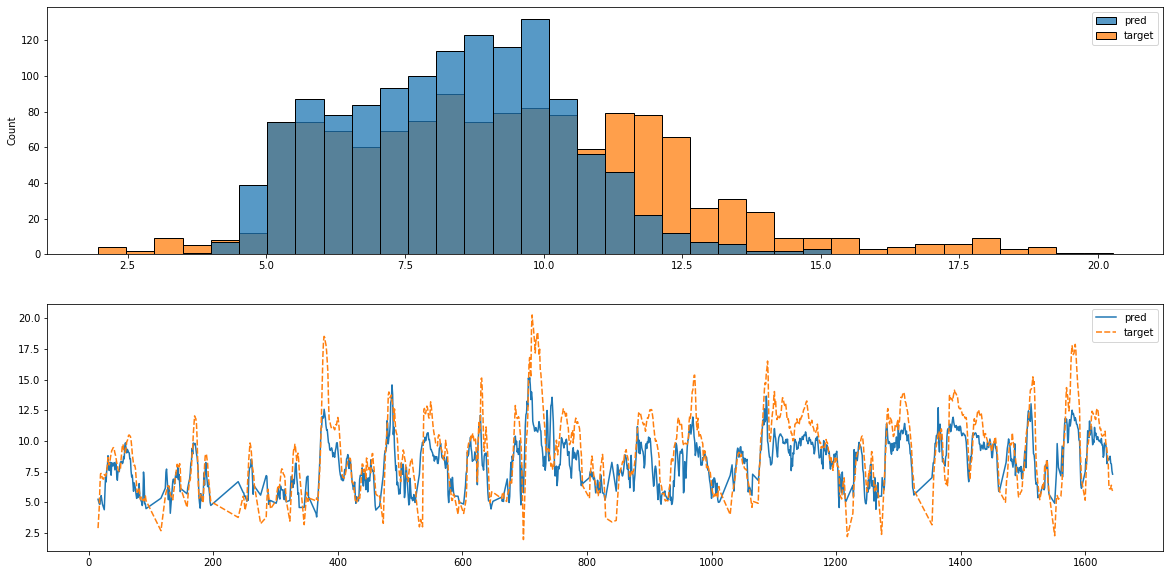

In [88]:
X_dl = X_fort.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn_fort = model_fort.predict(X_dl)
pred_nn_fort = pred_nn_fort.reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn_fort, 'target':Y_fort})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

***Final prediction :***

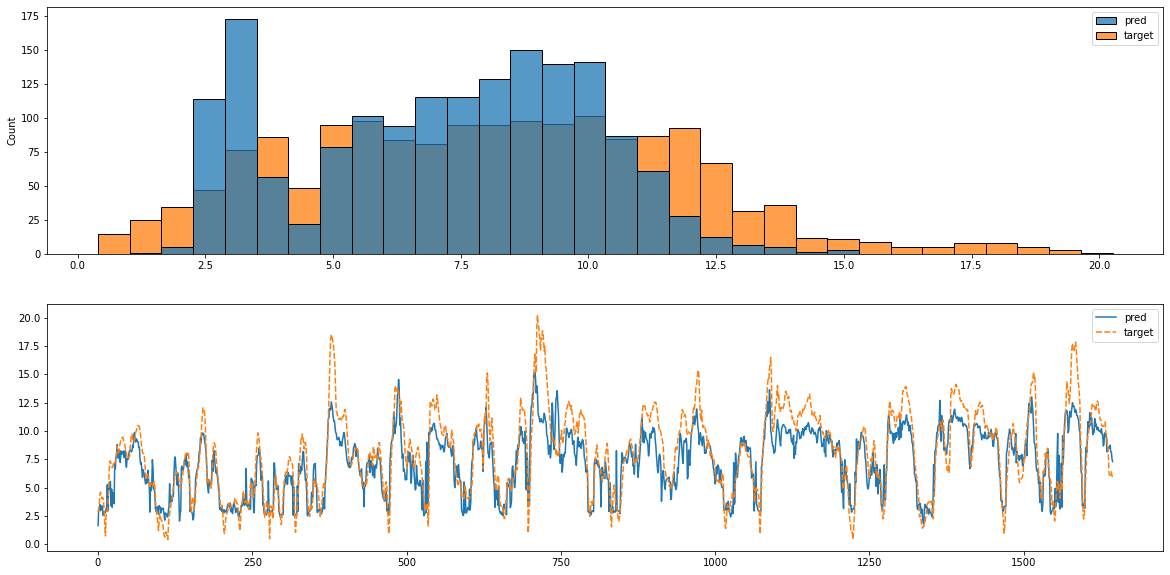

In [89]:
res=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res[j] = pred_nn_faible[i]
for i, j in enumerate(idx_fort[0]):
    res[j] = pred_nn_fort[i]

histo = pd.DataFrame(data={'pred':res, 'target':data['w10']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_amelioration_nn_pred_finale.png')

In [90]:
print(f"The MSE is : {np.mean((data['w10'] - res)**2)}")

The MSE is : 3.851470041450061


With this method, we have greatly improve our neural network performances for strong and low wind speed predictions.

## K-fold implementation

In [91]:
targets = pd.DataFrame(data={'w10':data['w10']})

In [92]:
loss, acc = test_k_fold(3, X, targets, 3, 32, batch_size=64,epochs=20)

[>--]
[>>-]
[>>>]


For our k-fold implementation, we decided to use 3 folds, so our model train himself with 66% of data as training set and 33% of data as test set. 
It's close to our other models that train with 70% of data as training set and 30% of data as test set.

In [93]:
print(loss)

        loss
0  12.569378
1  15.109334
2   9.396725


            loss
count   3.000000
mean   12.358479
std     2.862138
min     9.396725
25%    10.983051
50%    12.569378
75%    13.839356
max    15.109334


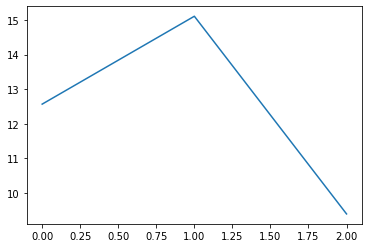

In [94]:
print(loss.describe())
plt.plot(loss)